In [2]:
pip install cleantext

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopy
import folium
from sklearn.preprocessing import StandardScaler
from geopy.geocoders import Nominatim, GoogleV3
from folium.plugins import MarkerCluster
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import nltk
from textblob import TextBlob
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from textblob import TextBlob
import re
import nltk
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from cleantext import clean as cleaner
from sklearn.decomposition import TruncatedSVD

In [5]:
geo = pd.read_csv('/content/geolocation_olist_public_dataset.csv')
order = pd.read_csv('/content/olist_public_dataset_v2.csv')
cust = pd.read_csv('/content/olist_public_dataset_v2_customers.csv')
pay = pd.read_csv('/content/olist_public_dataset_v2_payments.csv')
trans = pd.read_csv('/content/product_category_name_translation.csv')

In [1]:
# Geolocation Exploration

In [6]:
geo.head()


,zip_code_prefix,city,state,lat,lng
0,10,sao paulo,sp,-23.547807,-46.636122
1,10,sao paulo,sp,-23.546081,-46.644820
2,10,sao paulo,sp,-23.540984,-46.642569
3,10,sao paulo,sp,-23.546758,-46.645771
4,10,sao paulo,sp,-23.546362,-46.643073


In [7]:
geo = geo.drop_duplicates(subset=None, keep='first', inplace=False)

In [8]:
centroid = geo.groupby('zip_code_prefix').agg({
    'lat': 'median',
    'lng': 'median',
    'city': pd.Series.mode
}).reset_index()
centroid['count'] = geo.groupby('zip_code_prefix').size().reset_index(
    name='counts')['counts']

In [9]:
import plotly
import plotly.express as px

token = 'pk.eyJ1IjoiZmFhdGhpcjk4IiwiYSI6ImNrMGVxMTl5dzBiZHYzYm1wMm15b2RhcXQifQ.InHG7-SGeNMtnnfkvIVCRg'
fig = px.scatter_mapbox(centroid,
                        lat="lat",
                        lon="lng",
                        size="count",
                        color="count",
                        size_max=8,
                        color_continuous_scale=px.colors.sequential.Redor,
                        zoom=2.7)
fig.update_layout(mapbox_style="outdoors", mapbox_accesstoken=token)
fig.show()

In [10]:
#revenue distribution
order.head()

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1.0,1.0,2017-01-31 17:19:01.000000,2017-02-01 02:41:21.549551,2017-03-15 00:00:00.000000,2017-02-06 11:04:24.154259,...,51.0,625.0,1.0,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5.0,NaN,NaN,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00
1,59af46052a799e80e2f0c665c587731d,delivered,15.00,15.10,1.0,1.0,2017-09-09 19:52:54.000000,2017-09-10 20:03:31.535281,2017-10-02 00:00:00.000000,2017-09-13 20:17:41.296915,...,44.0,1428.0,2.0,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5.0,NaN,entrega em 2 dias produto c boa qualidade otim...,2017-09-14 00:00:00.000000,2017-09-15 03:43:47+00:00
2,a3e6136894621db402a772c6bc72a12a,delivered,238.90,18.00,1.0,1.0,2017-01-30 17:00:09.000000,2017-01-30 17:31:25.438253,2017-03-07 00:00:00.000000,2017-02-06 15:43:04.758566,...,55.0,637.0,1.0,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5.0,NaN,produto veio antes do prazo informado muito ob...,2017-02-07 00:00:00.000000,2017-02-10 14:18:53+00:00
3,b675ea5a618922f6e679e30531b8957b,delivered,29.99,18.23,1.0,1.0,2018-03-11 18:18:36.000000,2018-03-11 18:30:37.931962,2018-04-03 00:00:00.000000,2018-04-03 20:36:43.778451,...,55.0,617.0,1.0,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4.0,NaN,NaN,2018-04-04 00:00:00.000000,2018-04-05 02:52:31+00:00
4,195a8be6794c487fe6cfbb97b7c61902,delivered,295.99,47.65,1.0,1.0,2017-04-20 08:01:08.000000,2017-04-25 08:05:40.405383,2017-05-24 00:00:00.000000,2017-05-04 18:47:45.721758,...,49.0,558.0,2.0,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5.0,NaN,NaN,2017-05-05 00:00:00.000000,2017-05-08 15:20:18+00:00


In [11]:
geo_order = pd.merge(centroid,
                     order,
                     how='right',
                     left_on='zip_code_prefix',
                     right_on='customer_zip_code_prefix')

In [12]:
geo_rev = geo_order.groupby('customer_zip_code_prefix').agg({
    'lat':
    'median',
    'lng':
    'median',
    'order_products_value':
    'sum'
}).reset_index()

In [13]:
import plotly.graph_objects as go
fig = go.Figure(
    go.Densitymapbox(lat=geo_rev.lat,
                     lon=geo_rev.lng,
                     z=geo_rev.order_products_value,
                     radius=10))
fig.update_layout(mapbox_style="stamen-terrain",
                  mapbox_center_lon=-50,
                  mapbox_center_lat=-16,
                  mapbox_zoom=2.7)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [14]:
 #customer distribution

In [15]:
geo_order = geo_order.dropna(subset=['zip_code_prefix'])
geo_cust = geo_order.groupby('customer_zip_code_prefix').agg({
    'lat':
    'median',
    'lng':
    'median',
    'customer_id':
    'count'
}).reset_index()


In [17]:
import plotly.graph_objects as go
fig = go.Figure(
    go.Densitymapbox(lat=geo_cust.lat,
                     lon=geo_cust.lng,
                     z=geo_cust.customer_id,
                     radius=10))
fig.update_layout(mapbox_style="stamen-terrain",
                  mapbox_center_lon=-50,
                  mapbox_center_lat=-16,
                  mapbox_zoom=2.7)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [19]:
#conclusion : for brnading they should expand around west and north brazil

In [20]:
#2. Time period exploration
geo_order['order_delivered_customer_date'] = pd.to_datetime(
    geo_order['order_delivered_customer_date'])
geo_order['order_estimated_delivery_date'] = pd.to_datetime(
    geo_order['order_estimated_delivery_date'])

In [21]:
geo_order = geo_order.dropna(subset=['order_delivered_customer_date'])

In [22]:
geo_order['range_time'] = (
    geo_order['order_delivered_customer_date'] -
    geo_order['order_estimated_delivery_date']).astype('timedelta64[D]')

In [23]:
delay = geo_order['range_time'][geo_order['range_time'] > 0]
early = abs(geo_order['range_time'][geo_order['range_time'] < 0])

In [24]:
#early delivery

In [25]:
bins = [0, 3, 7, 14, 30, 90]
labels = [
    '1-3 days', '4-7 days', '7-14 days', '14-30 days', 'More than 1 month'
]
early = pd.cut(early, bins=bins, labels=labels)

<Axes: xlabel='count', ylabel='range_time'>

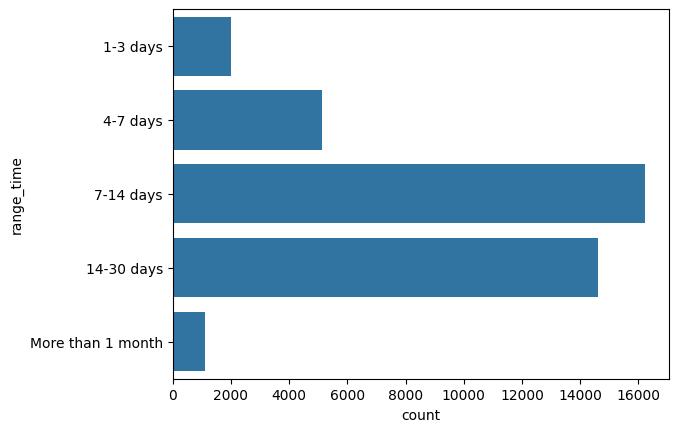

In [26]:
sns.countplot(y=early)

In [27]:
#delay delivery

In [28]:
bins = [0, 3, 7, 14, 30, 90, 300]
labels = [
    '1-3 days', '4-7 days', '7-14 days', '14-30 days', '1-3 month',
    'More than 3 months'
]
delay = pd.cut(delay, bins=bins, labels=labels)

<Axes: xlabel='count', ylabel='range_time'>

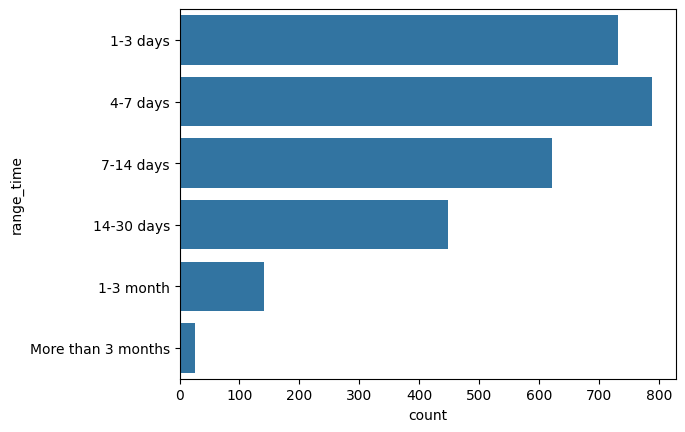

In [29]:
sns.countplot(y=delay)

In [30]:
geo_order['range_time_default'] = geo_order['range_time'].apply(
    lambda x: 1 if x > 0 else 0)

In [31]:
delay_place = geo_order.groupby('zip_code_prefix').agg({
    'lat':
    'median',
    'lng':
    'median',
    'range_time_default':
    'mean'
})

In [32]:
fig = go.Figure(
    go.Densitymapbox(lat=delay_place.lat,
                     lon=delay_place.lng,
                     z=delay_place.range_time_default,
                     radius=10))
fig.update_layout(mapbox_style="stamen-terrain",
                  mapbox_center_lon=-50,
                  mapbox_center_lat=-16,
                  mapbox_zoom=2.8)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [33]:
#conclusion
normal = geo_order['range_time'][geo_order['range_time'] == 0]
print('normal:',
      round(normal.count() * 100 / geo_order['range_time'].count(),
            3), '%', '\nearly:',
      round(early.count() * 100 / geo_order['range_time'].count(), 3), '%',
      '\ndelay:',
      round(delay.count() * 100 / geo_order['range_time'].count(), 3), '%')

normal: 1.243 % 
early: 92.252 % 
delay: 6.498 %


In [34]:
#promotion timing

In [35]:
order['order_purchase_timestamp'] = pd.to_datetime(
    order['order_purchase_timestamp'])


In [36]:
best_time_hours = (order.order_purchase_timestamp).dt.hour

<ipython-input-37-d302ddd6c726>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='order_purchase_timestamp', ylabel='Density'>

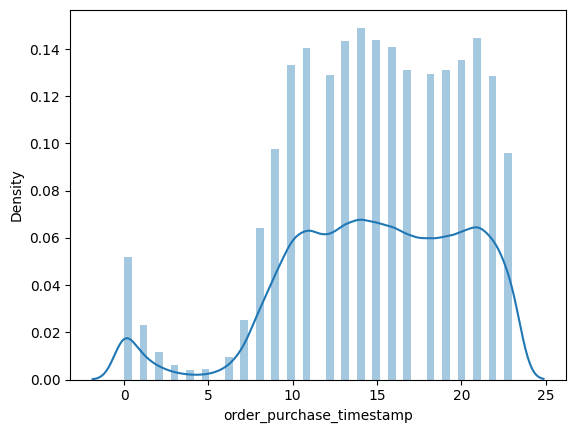

In [37]:
sns.distplot(best_time_hours)

In [38]:
#best day

<ipython-input-39-aae4c89590be>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='order_purchase_timestamp', ylabel='Density'>

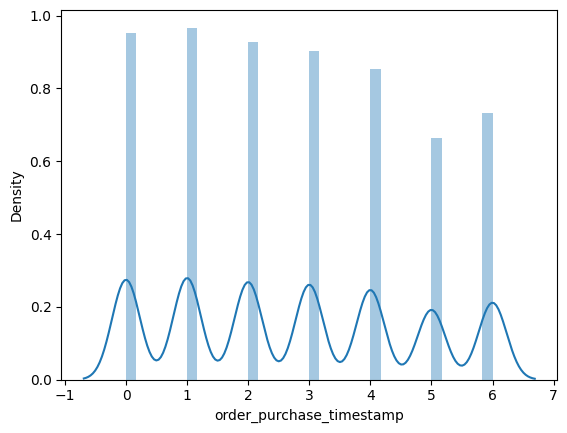

In [39]:
best_time_day = order.order_purchase_timestamp.apply(lambda x: x.weekday())
sns.distplot(best_time_day)

<ipython-input-40-18e6b480f70e>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='order_purchase_timestamp', ylabel='Density'>

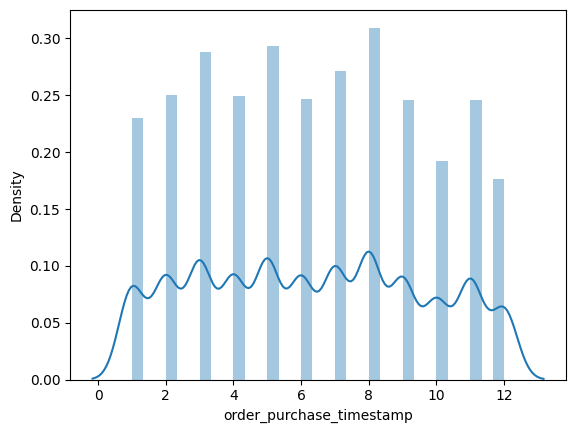

In [40]:
#best month
best_time_month = (order.order_purchase_timestamp).dt.month
sns.distplot(best_time_month)

In [42]:
#conclusion - the company should promote or release new products on
# hour: 10am -22pm
# day: tuesday, monday
#month : aug , feb

In [43]:
#3. customer behaviour exploration

In [44]:
cust.head()

,customer_id,customer_unique_id
0,0000ca4ff2795842fd6b122c6d974468,ac0e5d7f07043dd32831bdad3b99ad26
1,00010f206878ba01f199aec4237de72e,4ed24aaed4079fe0661c0e4b3b420dff
2,00012a2ce6f8dcda20d059ce98491703,7e0e291c0f4fc2d69208954d26ed0586
3,000161a058600d5901f007fab4c27140,ff1dcb27ea444eddb94ea5fea77b875c
4,00017f1d6cce0d56046219a2cfabcbbb,237130c4b6717031ed62d9d0b16fd94f


In [45]:
cust = cust.drop_duplicates(subset=None, keep='first', inplace=False)

In [46]:
order_cust = pd.merge(cust,
                      order,
                      how='right',
                      left_on='customer_id',
                      right_on='customer_id')

In [47]:
order_cust = order_cust.dropna(subset=['order_aproved_at'])
order_cust['order_aproved_at'] = pd.to_datetime(order_cust['order_aproved_at'])
order_cust['latest'] = max(order_cust.order_aproved_at)
order_cust[
    'range_time'] = order_cust['latest'] - order_cust['order_aproved_at']
recent = order_cust.groupby('customer_unique_id').agg({
    'range_time': 'min'
}).astype('timedelta64[D]')

In [48]:
frequent = order_cust.groupby('customer_unique_id').agg(
    {'order_items_qty': 'sum'})

In [49]:
monetary = order_cust.groupby('customer_unique_id').agg(
    {'order_products_value': 'sum'})

In [50]:
tenure = order_cust.groupby('customer_unique_id').agg({
    'range_time': 'max'
}).astype('timedelta64[D]')

In [51]:
rfmt = pd.concat([recent, frequent, monetary, tenure], axis=1)
rfmt.columns = ['recency', 'frequency', 'monatary', 'tenure']

In [52]:
rfmt.describe()

,recency,frequency,monatary,tenure
count,43177.000000,43177.00000,43177.000000,43177.000000
mean,307.720036,1.14788,133.916691,309.312805
std,157.418603,0.56463,190.343992,157.554188
min,0.000000,1.00000,2.000000,0.000000
25%,189.000000,1.00000,49.000000,190.000000
50%,306.000000,1.00000,87.000000,306.000000
75%,428.000000,1.00000,149.900000,430.000000
max,742.000000,20.00000,7388.000000,742.000000


In [53]:
label1 = [5, 4, 3, 2, 1]
label2 = [1, 2, 3, 4, 5]
rfmt['R'] = pd.qcut(rfmt['recency'],
                    q=[0, 0.2, 0.4, 0.6, 0.8, 1],
                    labels=label1)
rfmt['F'] = pd.cut(rfmt['frequency'], bins=[0, 1, 2, 3, 5, 900], labels=label2)
rfmt['M'] = pd.qcut(rfmt['monatary'],
                    q=[0, 0.2, 0.4, 0.6, 0.8, 1],
                    labels=label2)
rfmt['T'] = pd.qcut(rfmt['tenure'],
                    q=[0, 0.2, 0.4, 0.6, 0.8, 1],
                    labels=label2)

In [54]:
rfmt = rfmt.reset_index()

In [55]:
best = rfmt[rfmt.R.isin([4, 5]) & rfmt.F.isin([4, 5]) & rfmt.M.isin([4, 5])]
best['segment'] = 'BEST'

<ipython-input-55-30df329666ed>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
loyal_spender = rfmt[rfmt['R'].isin([4, 5]) & rfmt['F'].isin([2, 3])
                     & rfmt['M'].isin([2, 3]) & rfmt['T'].isin([3, 4, 5])]
loyal_spender['segment'] = 'LOYAL SPENDER'

<ipython-input-56-3848ca97717d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
potential_loyal = rfmt[rfmt['R'].isin([4, 5]) & rfmt['F'].isin([2, 3])
                       & rfmt['M'].isin([2, 3]) & rfmt['T'].isin([1, 2])]
potential_loyal['segment'] = 'POTENTIAL LOYAL'

new_cust = rfmt[rfmt['R'].isin([4, 5]) & rfmt['F'].isin([1])
                & rfmt['M'].isin([1]) & rfmt['T'].isin([1, 2])]
new_cust['segment'] = 'NEW CUSTOMER'

loyal_cust = rfmt[rfmt['R'].isin([4, 5]) & rfmt['F'].isin([1])
                  & rfmt['M'].isin([1]) & rfmt['T'].isin([3, 5])]
loyal_cust['segment'] = 'LOYAL CUSTOMER'
promising = rfmt[rfmt['R'].isin([2, 3]) & rfmt['F'].isin([3, 5])
                 & rfmt['M'].isin([3, 5])]
promising['segment'] = 'PROMISING'
cant_lose = rfmt[rfmt['R'].isin([1]) & rfmt['F'].isin([4, 5])
                 & rfmt['M'].isin([4, 5])]
cant_lose['segment'] = 'CAN NOT LOSE'

about_to_sleep = rfmt[rfmt['R'].isin([1]) & rfmt['F'].isin([4, 5])
                      & rfmt['M'].isin([4, 5])]
about_to_sleep['segment'] = 'ABOUT TO SLEEP'

hibernating = rfmt[rfmt['R'].isin([1]) & rfmt['F'].isin([2, 3])
                   & rfmt['M'].isin([2, 3])]
hibernating['segment'] = 'HIBERNATING'

lost = rfmt[rfmt['R'].isin([1]) & rfmt['F'].isin([1]) & rfmt['M'].isin([1])
            & rfmt['T'].isin([1])]
lost['segment'] = 'HIBERNATING'

rfmt_segment = pd.concat([
    best, loyal_spender, potential_loyal, new_cust, loyal_cust, promising,
    cant_lose, about_to_sleep, hibernating, lost
])

rfmt_segment.sample(10)

<ipython-input-57-f55c64f2b798>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-57-f55c64f2b798>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-57-f55c64f2b798>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-57-f55c64

,customer_unique_id,recency,frequency,monatary,tenure,R,F,M,T,segment
39272,e8622aeae1ea24c4a8dfd6001860c156,148.0,1.0,35.90,148.0,5,1,1,1,NEW CUSTOMER
30246,b3140fb5957bc8a23975cc820459da8d,52.0,1.0,39.00,52.0,5,1,1,1,NEW CUSTOMER
26911,9f37ace8161644b91ef97928b10d60bf,218.0,1.0,19.90,218.0,4,1,1,2,NEW CUSTOMER
39712,eb0ca846fda22d9ce94d53cb0b7e2eb4,227.0,1.0,29.90,227.0,4,1,1,2,NEW CUSTOMER
19233,7147671b0007b65b3e71f83e54b96183,254.0,1.0,23.90,254.0,4,1,1,2,NEW CUSTOMER
29035,abeb01a51bff516ac01f6559b77b048a,121.0,1.0,34.90,121.0,5,1,1,1,NEW CUSTOMER
27939,a5271911762e989c7f13e0a22ae49bfb,82.0,1.0,34.90,82.0,5,1,1,1,NEW CUSTOMER
17535,66e58e79eb66e3d94179f116a5edeadb,563.0,3.0,86.70,563.0,1,3,3,5,HIBERNATING
5456,1ff1be3558bba1ece56560c683fe1a99,216.0,1.0,17.91,216.0,4,1,1,2,NEW CUSTOMER
6794,284bb187e98f29fbec1b71a945fbffe2,75.0,1.0,30.00,75.0,5,1,1,1,NEW CUSTOMER


In [58]:
#4. product exploration

In [59]:
trans.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [60]:
order_trans = pd.merge(trans,
                       order,
                       how='right',
                       on=['product_category_name', 'product_category_name'])
order_en = order_trans.drop(['product_category_name'], axis=1)

In [61]:
 order_en.head()


,product_category_name_english,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,health_beauty,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1.0,1.0,2017-01-31 17:19:01,2017-02-01 02:41:21.549551,2017-03-15 00:00:00.000000,...,51.0,625.0,1.0,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5.0,NaN,NaN,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00
1,computers_accessories,59af46052a799e80e2f0c665c587731d,delivered,15.00,15.10,1.0,1.0,2017-09-09 19:52:54,2017-09-10 20:03:31.535281,2017-10-02 00:00:00.000000,...,44.0,1428.0,2.0,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5.0,NaN,entrega em 2 dias produto c boa qualidade otim...,2017-09-14 00:00:00.000000,2017-09-15 03:43:47+00:00
2,auto,a3e6136894621db402a772c6bc72a12a,delivered,238.90,18.00,1.0,1.0,2017-01-30 17:00:09,2017-01-30 17:31:25.438253,2017-03-07 00:00:00.000000,...,55.0,637.0,1.0,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5.0,NaN,produto veio antes do prazo informado muito ob...,2017-02-07 00:00:00.000000,2017-02-10 14:18:53+00:00
3,bed_bath_table,b675ea5a618922f6e679e30531b8957b,delivered,29.99,18.23,1.0,1.0,2018-03-11 18:18:36,2018-03-11 18:30:37.931962,2018-04-03 00:00:00.000000,...,55.0,617.0,1.0,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4.0,NaN,NaN,2018-04-04 00:00:00.000000,2018-04-05 02:52:31+00:00
4,furniture_decor,195a8be6794c487fe6cfbb97b7c61902,delivered,295.99,47.65,1.0,1.0,2017-04-20 08:01:08,2017-04-25 08:05:40.405383,2017-05-24 00:00:00.000000,...,49.0,558.0,2.0,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5.0,NaN,NaN,2017-05-05 00:00:00.000000,2017-05-08 15:20:18+00:00


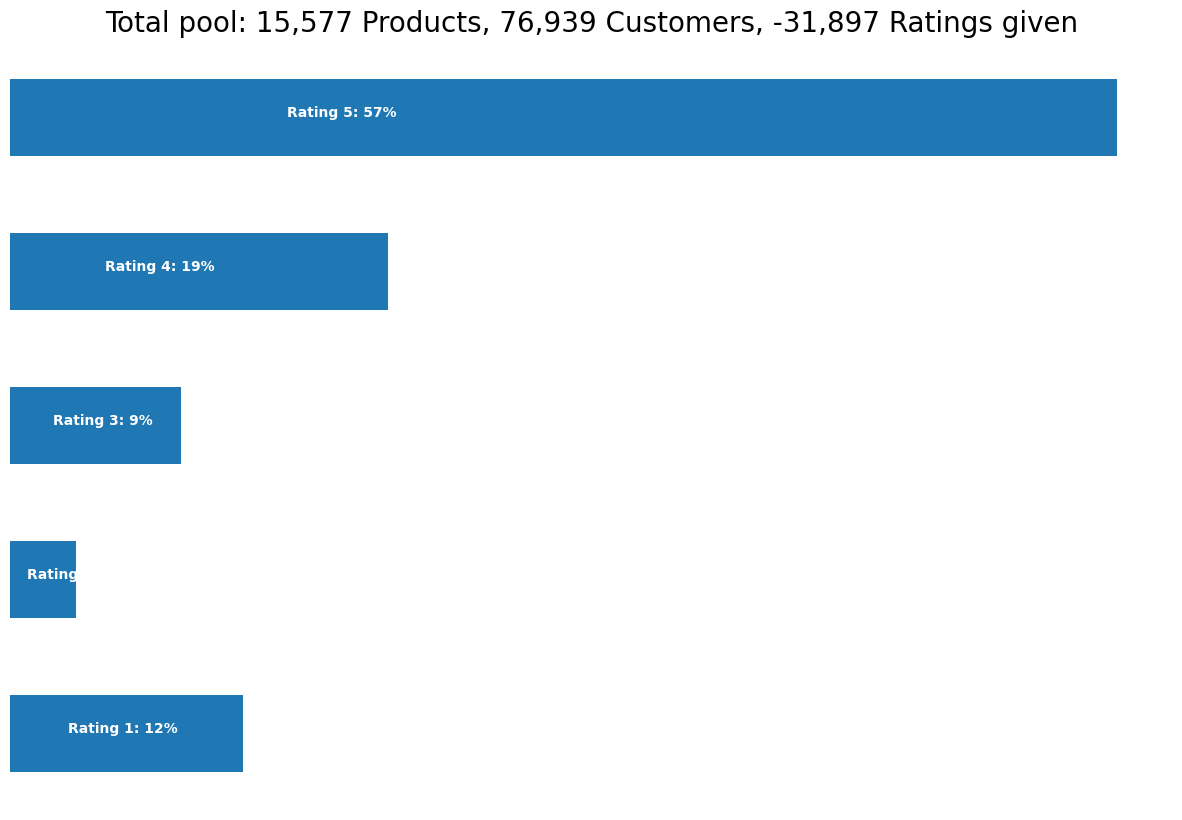

In [62]:
n = order_en.groupby('review_score')['review_score'].agg(['count'])

prod_count = order_en['product_id'].nunique()

cust_count = cust['customer_unique_id'].nunique() - prod_count

rating_count = order_en['review_score'].count() - cust_count

ax = n.plot(kind='barh', legend=False, figsize=(15, 10))
plt.title(
    'Total pool: {:,} Products, {:,} Customers, {:,} Ratings given'.format(
        prod_count, cust_count, rating_count),
    fontsize=20)
plt.axis('off')

for i in range(1, 6):
    ax.text(n.iloc[i - 1][0] / 4,
            i - 1,
            'Rating {}: {:.0f}%'.format(i,
                                        n.iloc[i - 1][0] * 100 / n.sum()[0]),
            color='white',
            weight='bold')

In [63]:
pop_prod = pd.DataFrame(
    order_en.groupby('product_id')['review_score'].count())
most_popular = pop_prod.sort_values('review_score', ascending=False)
most_popular.head(10)

,review_score
product_id,
99a4788cb24856965c36a24e339b6058,291
aca2eb7d00ea1a7b8ebd4e68314663af,283
389d119b48cf3043d311335e499d9c6b,221
53759a2ecddad2bb87a079a1f1519f73,200
d1c427060a0f73f6b889a5c7c61f2ac4,199
422879e10f46682990de24d770e7f83d,193
53b36df67ebb7c41585e8d54d6772e08,181
368c6c730842d78016ad823897a372db,174
154e7e31ebfa092203795c972e5804a6,163


<Axes: ylabel='product_id'>

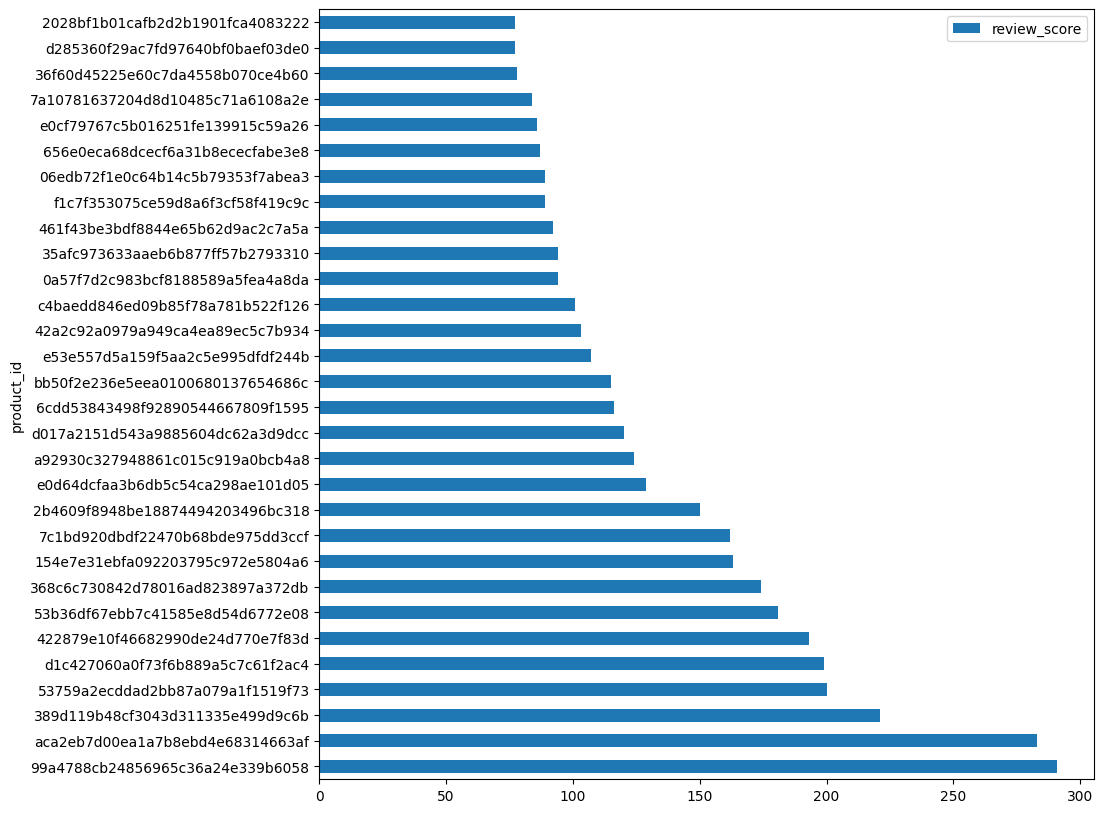

In [64]:
plt.rcParams['figure.figsize'] = (10, 10)
most_popular.head(30).plot(kind="barh")

In [66]:
#product reccommendation system


In [67]:
order.head()

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1.0,1.0,2017-01-31 17:19:01,2017-02-01 02:41:21.549551,2017-03-15 00:00:00.000000,2017-02-06 11:04:24.154259,...,51.0,625.0,1.0,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5.0,NaN,NaN,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00
1,59af46052a799e80e2f0c665c587731d,delivered,15.00,15.10,1.0,1.0,2017-09-09 19:52:54,2017-09-10 20:03:31.535281,2017-10-02 00:00:00.000000,2017-09-13 20:17:41.296915,...,44.0,1428.0,2.0,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5.0,NaN,entrega em 2 dias produto c boa qualidade otim...,2017-09-14 00:00:00.000000,2017-09-15 03:43:47+00:00
2,a3e6136894621db402a772c6bc72a12a,delivered,238.90,18.00,1.0,1.0,2017-01-30 17:00:09,2017-01-30 17:31:25.438253,2017-03-07 00:00:00.000000,2017-02-06 15:43:04.758566,...,55.0,637.0,1.0,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5.0,NaN,produto veio antes do prazo informado muito ob...,2017-02-07 00:00:00.000000,2017-02-10 14:18:53+00:00
3,b675ea5a618922f6e679e30531b8957b,delivered,29.99,18.23,1.0,1.0,2018-03-11 18:18:36,2018-03-11 18:30:37.931962,2018-04-03 00:00:00.000000,2018-04-03 20:36:43.778451,...,55.0,617.0,1.0,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4.0,NaN,NaN,2018-04-04 00:00:00.000000,2018-04-05 02:52:31+00:00
4,195a8be6794c487fe6cfbb97b7c61902,delivered,295.99,47.65,1.0,1.0,2017-04-20 08:01:08,2017-04-25 08:05:40.405383,2017-05-24 00:00:00.000000,2017-05-04 18:47:45.721758,...,49.0,558.0,2.0,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5.0,NaN,NaN,2017-05-05 00:00:00.000000,2017-05-08 15:20:18+00:00


In [68]:
order_rating = order.loc[:, ['customer_id', 'product_id', 'review_score']]

In [69]:
order_rating = order_rating[order_rating['product_id'].isin(
    order_rating['product_id'].value_counts()[
        order_rating['product_id'].value_counts() > 10].index)]

In [70]:
order_rating = order_rating.reset_index()

In [71]:
ratings_utility_matrix = order_rating.pivot_table(values='review_score',
                                                  index='customer_id',
                                                  columns='product_id',
                                                  fill_value=0)
ratings_utility_matrix.head()

product_id,008cff0e5792219fae03e570f980b330,00ba6d766f0b1d7b78a5ce3e1e033263,014a8a503291921f7b004a5215bb3c36,0152f69b6cf919bcdaf117aa8c43e5a2,016711f78a6a87696645db0a6a834826,017692475c1c954ff597feda05131d73,027cdd14a677a5834bc67a9789db5021,02ce467092b184e71d3967d29110adc1,03e4e6709b7d6415746769c0bc3e9131,060cb19345d90064d1015407193c233d,...,fbd4031ddbc3d02b95834b62769d3ad0,fc1d8637c0268af3db482c14b7ef8e75,fca62108387e25005784da2f551466a1,fcf6ad274391aea29f5d6e5ef9da5050,fe01b643060a6446e59f58e3021e66b3,fe077ec80df6b4ee60bb4498d5ab1962,fe6a9515d655fa7936b8a7c841039f34,fe9dfbe7f974621789683b7b78be2a16,fed5c40c27e1c88560a9e92d82ee0825,ffc9caf33e2d1e9f44e3e06da19085f7
customer_id,,,,,,,,,,,,,,,,,,,,,
0004164d20a9e969af783496f3408652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000c88c401a87f064691b4bea3eb86b4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00128e9bfb3585454004b6931ae6e080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0019152890452bcee2c9b52dad237a89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00193d47b6bdf6be51d9d973d85c9f52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
ratings_utility_matrix.shape

(16192, 600)

In [73]:
X = ratings_utility_matrix.T
X.head()

customer_id,0004164d20a9e969af783496f3408652,000c88c401a87f064691b4bea3eb86b4,00128e9bfb3585454004b6931ae6e080,0019152890452bcee2c9b52dad237a89,00193d47b6bdf6be51d9d973d85c9f52,0019c9aaad15b043c48f0a1180f22ce8,001e5ec55def8adcdd22a9fe12976320,001f6f1a5e902ad14e1f709a7215de11,002515894b12f4902f12da2903959f79,002d625f5aa91af458ffb948d999189a,...,ffdf9e18cb86437d4f1e8d2f90462767,ffe642291d0c94528389d64c07ec8341,ffe83113e5531bfcec43e28ededd2a62,ffe8924e728e73b9dbaa134a42510025,ffeaa6d37b3691d54a01171f6562f44f,ffed827348cd4b083956ce2b634b763b,ffef72b7f958851d4c473c4b3913ecf6,fff212062d600f2e1d53f3c5d4a25138,fff4f0c85a4d710abe06599e1ed08a42,fff5ca85c16ebb7e531dbd4a08756567
product_id,,,,,,,,,,,,,,,,,,,,,
008cff0e5792219fae03e570f980b330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ba6d766f0b1d7b78a5ce3e1e033263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
014a8a503291921f7b004a5215bb3c36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0152f69b6cf919bcdaf117aa8c43e5a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
016711f78a6a87696645db0a6a834826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
X.shape

(600, 16192)

In [75]:
def fitsystemrecommendation(ratings_utility_matrix):
    X = ratings_utility_matrix.T
    SVD = TruncatedSVD(n_components=10)
    decomposed_matrix = SVD.fit_transform(X)
    correlation_matrix = np.corrcoef(decomposed_matrix)
    return correlation_matrix

In [76]:
correlation_matrix = fitsystemrecommendation(ratings_utility_matrix)

In [77]:
def systemrecommendation(prod_id):
    order_rating.index[order_rating['product_id'] == prod_id].tolist()[1]
    product_names = list(X.index)
    product_ID = product_names.index(prod_id)
    correlation_product_ID = correlation_matrix[product_ID]
    Recommend = list(X.index[correlation_product_ID > 0.70])
    Recommend.remove(prod_id)
    return pd.DataFrame(Recommend[0:9], columns=['Recommendation'])

In [81]:
#For example, the following program show you the recommendation if you buy product with product id: '99a4788cb24856965c36a24e339b6058'.

In [82]:
systemrecommendation('99a4788cb24856965c36a24e339b6058')

,Recommendation
0,0efc91aa52d1f0669126d3000a94279b
1,0fa81e7123fd0ebe03adbbe99d912827
2,283dc451ad3918badb976d56ff887289
3,35afc973633aaeb6b877ff57b2793310
4,42a2bd596fda1baef5719cb74f73030c
5,98b22c1129886cbd7fcae69d1c93e442
6,eebbed5ed3b134eceb717496c47652ba
7,f2e53dd1670f3c376518263b3f71424d


In [83]:
#---
#To sum up, the analysis above can be the recommendation for the company to improve the market. I hope the recommendation can be useful for the company concerned. Thank you.